## Purpose:

Load data and create query/response pairs in different ways

## Initialize

In [6]:
import pandas as pd
import pickle

# Custom
from processing import tag_utterances
from processing import load_sem_types
from processing import DataPipeline
pd.set_option('display.max_columns', 500) # more columns displayed at once

# Set path for importing data
data_instance = DataPipeline(comments_path = '../data/reddit_comments_askDocs_2014_to_2018_03.gz',
                            posts_path = '../data/original_posts_under_askDocs_subreddit_id.gz')

There is a lot that could be done with formatting the data for training conversations:

* Option 1: All responses are equal: This is probably not going to work. 
    * Treat every thread as a conversation
    * Every comment in the thread as a response to the original AskDocs
* Option 2 **Models a back-and-forth** interaction between bot and human: 
 * There might be a sub-option here: We get more data if we don't join with posts (i.e. the post that started the thread). Each post that had the original post as its parent_id would become the top level but be eliminated if it did not have post response.
* Option 3 **Response Retrieval**:
    * The initial post is the question first response by the certified clinition is the response

## Option 1: All responses are equal

* Each title of the thread is listed as the question 
* Every comment in that thread is listed as the answer
* The comment of the first query/post asked by the original author is ignored

In [2]:

df = data_instance.load_full_thread()

print('\nCount of threads:')
df['is_thread_start'].value_counts()

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)
Count of threads


0.0    108825
1.0     30710
Name: is_thread_start, dtype: int64

In [8]:
%%time
list_of_threads = df['link_id_short'].unique().tolist()

query = []
answer = []

# loop through all threads
for thread in list_of_threads:
    try:
        df_subset = df.loc[df['link_id_short']==thread]
        # assert there is one poster
        assert sum(df_subset['is_thread_start'].unique()) == 1

        thread_author = str(df_subset.loc[df_subset['is_thread_start']==1]['author'].unique()[0]).strip()
        thread_question = str(df_subset.loc[df_subset['is_thread_start']==1]['body'][0]).strip()


        thread_title = df_subset.title[df_subset.title.notnull()][0]

        try:
            thread_title_short = df_subset.url.unique()[1].split('/')[-2]
        except:
            thread_title_short = df_subset.url.unique()[1]


        thread_readers = df_subset.loc[df_subset['parent_id_short']==thread].author.tolist()

        if False:
            print('thread:',thread)
            print('thread_author:',thread_author)
            print('url:',df_subset.url.unique()[1])
            print('thread_title short:',thread_title_short)
            print('thread_title:',thread_title)
            print('thread_readers:',thread_readers)

        for index,row in df_subset.loc[df_subset['is_thread_start']!=1].iterrows():
            query.append({'author':thread_author,'reader':row['author'],'utterance':thread_title})
            answer.append({'author':row['author'], 'reader': thread_author,'utterance':row['body']})
    except:
        print(thread)
        
assert len(query)==len(answer)

CPU times: user 6min 25s, sys: 2.38 s, total: 6min 27s
Wall time: 6min 28s


In [17]:
pickle.dump(zip(query,answer),open( '../data/all_responses_equal.p', "wb" ))

In [170]:
for idx, row in df_subset.iterrows():
    print(df_subset.title[df_subset.title.notnull()][0])
    #print(row['url'],row['body'])
    print()

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!

Out of hand tonsil infection. Help!



In [171]:
for idx in range(len(query)):
    print("Q:", query[idx])
    print("A:", answer[idx])
    print()
print('Number of Q/A:',len(query))

Q: {'author': 'dpeters14fuck', 'reader': 'ebast', 'utterance': 'Out of hand tonsil infection. Help!'}
A: {'author': 'ebast', 'reader': 'dpeters14fuck', 'utterance': 'Well, then just be careful and try to avoid any kind of abdominal trauma. Best of luck! Get better soon so you can enjoy your vacations :)'}

Q: {'author': 'dpeters14fuck', 'reader': 'dpeters14fuck', 'utterance': 'Out of hand tonsil infection. Help!'}
A: {'author': 'dpeters14fuck', 'reader': 'dpeters14fuck', 'utterance': "Thanks for the advice and well wishing! It's now wednesday and I've been all good at work so I guess as long as I'm not straining myself too much I'll be all good"}

Q: {'author': 'dpeters14fuck', 'reader': 'ebast', 'utterance': 'Out of hand tonsil infection. Help!'}
A: {'author': 'ebast', 'reader': 'dpeters14fuck', 'utterance': "You're welcome :) well, that's hard to say actually. Contact sports are like the classic thing you tell patients not to do because the spleen gets a little bigger during mono. I'

## Option 2: Every comment is a question and answer

There might be a sub-option here: We get more data if we don't join with posts (i.e. the post that started the thread). Each post that had the original post as its parent_id would become the top level but be eliminated if it did not have post response.

In [7]:
%%time
df = data_instance.load_full_thread()

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)
CPU times: user 7.94 s, sys: 1.02 s, total: 8.96 s
Wall time: 9.3 s


In [8]:
# heres the situation we're dealing with in terms of looking at which post belongs to which
df[['link_id_short','parent_id','parent_id_short','post_id','id']].head()

,link_id_short,parent_id,parent_id_short,post_id,id
1662,37o1az,t3_37o1az,37o1az,cvkbr58,cvkbr58
1663,37o1az,t1_cvnw8ly,cvnw8ly,cvnwkg4,cvnwkg4
2156,3exs68,t3_3exs68,3exs68,cwphyrq,cwphyrq
2549,399nb8,t1_cw2sr75,cw2sr75,cw2svpt,cw2svpt
2550,399nb8,t1_cw1xikq,cw1xikq,cw2fe2o,cw2fe2o


In [9]:
# all original posts
all_threads = df['link_id_short'].unique().tolist()
print(len(all_threads))

30710


In [10]:
imp_columns = ['link_id_short','parent_id','parent_id_short','post_id','id']
# example link_id 37o1az
df_example = df[df['link_id_short'] == '37o1az']

print('Num total posts:',df_example.shape)
print('Num first responses:',sum(df_example['parent_id_short'] == df_example['link_id_short']))

# original post
df_example[df_example['body'].str.contains("Pertinent facts")][imp_columns]

query = []
response = []

qr_pair = []
# Append top query
query_id = df_example[df_example['parent_id'].isnull()]['link_id_short'].iloc[0]
query_original = df_example[df_example['parent_id'].isnull()]['body'].iloc[0]
# Append responses to top query 
df_example2 = df_example[(~df_example['parent_id'].isnull()) &
                         (df_example['body'] != '[deleted]') & 
                         (df_example['parent_id_short'].str.contains(query_id))] # get the children

for resp in df_example2['body'].tolist():
    qr_pair.append((query_original,resp))
# Create list of ids to find children
len(df_example2['post_id'].unique())

Num total posts: (84, 28)
Num first responses: 21


18

In [11]:
#
df[(df['parent_id_short'].isin(['37o1az'])) &
   (df['body'] != '[deleted]') # some entries have been removed for some reason
  & (df['id'] == 'cvkbr58')]['id'].tolist()

['cvkbr58']

In [12]:
class QueryResponse:
    """
    Recursive search to create query response-pairs.
    """
    def __init__(self,parent_id_lst):
        self.parent_id_lst = parent_id_lst

        if type(self.parent_id_lst) == list:
            self.children_id_lst = pd_data_frame[(pd_data_frame['parent_id_short'].isin(self.parent_id_lst)) &
                                                 # some entries have been removed for some reason
                                                 (pd_data_frame['body'] != '[deleted]') 
                                                ]['id'].tolist()
        else:
            self.children_id_lst = pd_data_frame[(pd_data_frame['parent_id_short'] == self.parent_id_lst) &
                                                 # some entries have been removed for some reason
                                                 (pd_data_frame['body'] != '[deleted]') 
                                                ]['id'].tolist()
            
        # Given a list of parent ids, turn the cooresponding text for those into queries
        # and the entries whose are responses to the parent_ids given...turn those into responses.
        if type(parent_id_lst) == str:
            parent_id_lst = [parent_id_lst]
        query_response = []
        count = 0
        # for parent_id in parent_id_lst:
        while count < len(parent_id_lst):
            query = pd_data_frame[pd_data_frame['id'] == parent_id_lst[count]]['body'].iloc[0]
            children_ids = pd_data_frame[(pd_data_frame['parent_id_short']==parent_id_lst[count]) &
                                              # some entries have been removed for some reason
                                              (pd_data_frame['body'] != '[deleted]') 
                                             ]['id'].tolist()
            for child_id in children_ids:
                response = pd_data_frame[pd_data_frame['id'] == child_id]['body'].iloc[0]
                query_response.append((query,response))
            
            count += 1
            
        self.query_response = query_response     
    
    @property
    def child_elements(self):
        return [QueryResponse(a) for a in self.children_id_lst]
    
    # Return the list of (query,response) tuples
    @property
    def get_value(self):
        return self.query_response
    
def node_recurse_generator(node):
    """
    Iterates through all response/query pairs. "node" is a QueryResponse object.
    """
    yield node.query_response
    for n in node.child_elements:
        yield from node_recurse_generator(n)

In [6]:
print('Total num threads:',len(set(all_threads)))
# example threads
sample_threads = all_threads

Total num threads: 30710


In [7]:
%%time

# Global dataframe: can be set to test or for the full dataset
pd_data_frame = df
# Initialize
recursive_object = QueryResponse(sample_threads)
# Crawl through tree
layered_chats = list(node_recurse_generator(recursive_object))
print('Num conversations between a poster and 1 or more responses:',len(layered_chats))

Num conversations between a poster and 1 or more responses: 96113
CPU times: user 2h 24min 36s, sys: 47.3 s, total: 2h 25min 24s
Wall time: 2h 26min 19s


In [8]:
def unroll_chats(rolled_chats):
    """
    Since each level of discourse is returned as a singled list, to get one long set of discourse
    (and ignore any potential context) we need to join the individual lists together.
    """
    chats = []
    for layer in rolled_chats:
        if type(layer) == list:
            for chat in layer:
                chats.append(chat)
        elif type(layer) == tuple:
            print('only 1 conversation here')
            chats.append(chat)
    return chats

chats = unroll_chats(rolled_chats = layered_chats)

In [9]:
print(len(layered_chats))
print(len(chats))
print(len(set(chats)))

96113
96112
95546


In [10]:
chats[100:103]

[("Recently after every cold I seem to get a persistent dry cough long after the cold is gone. It's just a little tickle in the throat that keeps making me cough. I think it started after a vocal injury (overuse) that has made my throat more sensitive and prone to this after colds. I've tried over the counter meds with dextromethorphan and my doctor has prescribed benzonatate and hydrocodone saying the latter is the strongest stuff they've got, and it did absolutely nothing. I've also tried all the old wives remedies (honey, ginger tea, steam, etc) and no help either. \n\nWhat other Rx options are there that I can ask about? I've heard some people get temporary inhalers, would that be an option for me and what are the possible options? Which class/type of inhaler would be the best for treating cough? Steroid? Bronchodialator? Are there any over the counter options? ",
  'Have you tried an a antihistamine?  Zyrtec, Allegra, and/or Claritin?'),
 ("34, F, 5'7, 130-ish pounds, white, a cou

In [11]:
# save data from data creation option 2: Every comment is a question and answer
pickle.dump(chats,open( '../data/query_response_direct.p', "wb" ))

### Option 3 **Response Retrieval**:

* Disclaimer: According to original paper (https://arxiv.org/pdf/1506.08909.pdf) reddit data hypothesized to not suited very well for actual human-like conversation

In [2]:
%%time
df = data_instance.load_full_thread()
df_comments = data_instance.load_comments()

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)
Comments Table Shape: (557648, 24)
CPU times: user 14.9 s, sys: 1.66 s, total: 16.6 s
Wall time: 16.8 s


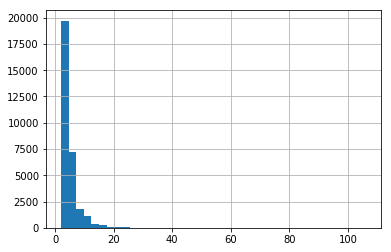

In [3]:
# distribution of turns
import matplotlib.pyplot as plt
%matplotlib inline
df['link_id_short'].value_counts().hist(bins=40);

In [4]:
import numpy as np
print('Turns in conversation for combined posts')
v = df['link_id_short'].value_counts().values
print('mean:', np.mean(v))
print('median:', np.median(v) )
print('min:',min(v))
print('max:',max(v))
print('Count of where turns equals 2:',sum(v==2))

Turns in conversation for combined posts
mean: 4.543633995441224
median: 4.0
min: 2
max: 106
Count of where turns equals 2: 7843


In [5]:
len(df)

139535

Note: although paper filtered by a minimum of 3 turns per conversation, I'm sticking with 2 since the goal is not a long-term conversation, but a inter-active response.

In [6]:
count = df[df['is_thread_start']==1]['body'].apply(lambda r: len(str(r).split()))
np.mean(count)

170.70797785737545

In [7]:
count = df[df['is_thread_start']==0]['body'].apply(lambda r: len(str(r).split()))
np.mean(count)

47.11861245118309

In [14]:
# Load chats from option 2
all_chats = pickle.load(open( '../data/query_response_direct.p', "rb" ))
all_chats = list(set(all_chats))
print(len(all_chats))

95561


In [16]:
all_chats[0][0]

"Greetings, first time here so forgive any mistakes.\n\nMy brother around 5 moths ago started making these weird noises every 15-30 seconds or so. Regardless of if he's talking, being silent, or even just ideally watching tv.\n\nHe can seem to slow down the frequency if he tries hard enough, but they come through so it's obviously involuntary at this point.\n\nI've made an [audio recording](http://vocaroo.com/i/s1ksr9Cs431T) to help better understand the noise, since the only description i could give is it sounds like a reverse hiccup or something. Also note that I removed some empty space from the recording so it sounds more frequent then it actually is.\n\n\nGeneral info:\n\nAge: 16\n\nSex: Male\n\nHeight: 5'5''\n\nWeight: 132 lbs\n\nRace: caucasianCausation \n\nLocation: Not relevant\n\nExisting relevant issues: none\n\nAudio link: http://vocaroo.com/i/s1ksr9Cs431T"

#### Perform any cleaning steps

In [31]:
%%time
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)

all_chats_new = []
for q,r in all_chats:
    q_cleaned = ' '.join(tknzr.tokenize(str(q)))
    r_cleaned = ' '.join(tknzr.tokenize(str(r)))
    all_chats_new.append((q_cleaned,r_cleaned))

CPU times: user 47.3 s, sys: 64.1 ms, total: 47.4 s
Wall time: 47.4 s


In [32]:
all_chats_new[0]

("Greetings , first time here so forgive any mistakes . My brother around 5 moths ago started making these weird noises every 15-30 seconds or so . Regardless of if he's talking , being silent , or even just ideally watching tv . He can seem to slow down the frequency if he tries hard enough , but they come through so it's obviously involuntary at this point . I've made an [ audio recording ] ( http://vocaroo.com/i/s1ksr9Cs431T ) to help better understand the noise , since the only description i could give is it sounds like a reverse hiccup or something . Also note that I removed some empty space from the recording so it sounds more frequent then it actually is . General info : Age : 16 Sex : Male Height : 5 ' 5 ' ' Weight : 132 lbs Race : caucasianCausation Location : Not relevant Existing relevant issues : none Audio link : http://vocaroo.com/i/s1ksr9Cs431T",
 'Does he feel built up tension release if he makes this sound ? Any new repetitive movements ?')

In [9]:
%%time
import random
def sample_negative_examples(positive_idx,N,num_examples=3):
    """
    Creates a list of random integesr not in the postive examples.
    
        positive_idx: the idx we don't want a random number for
        N: range from which a positive example can be generated
        num_examples: number of negative example indexes to generate
    """
    def generate_rand_int(positive_idx,N):
        neg_sample = random.randint(0,N-1)
        if positive_idx != neg_sample and neg_sample != None:
            return neg_sample
        else:
            generate_rand_int(positive_idx,N)
    
    random_int_list = []
    for num in range(num_examples):
        random_int_list.append(generate_rand_int(positive_idx,N))
    
    return random_int_list


# number of negative samples to use in training
num_negative_samples = 9

# Loop through all exchanges creating a set of size  n*(n + num_negative_examples)
all_chats_train = []
for i,v in enumerate(all_chats):

    
    neg_idx_lst = sample_negative_examples(positive_idx=i,N=len(all_chats),num_examples=num_negative_samples)
    for k in neg_idx_lst:
        if k == None:
            neg_idx_lst = sample_negative_examples(positive_idx=i,N=len(all_chats),num_examples=num_negative_samples)

    chat_set = []
    j = 0
    k= 0
    for sample in range(num_negative_samples + 1):
        if sample == 0:
            chat_set.append({'context':v[0],'utterance': v[1], 'label': 1, 'group':i ,'pivot_label': k})
        else:
            
            chat_set.append({'context':v[0],'utterance': all_chats[neg_idx_lst[j]][1], 'label': 0, 'group': i,'pivot_label': k })
            j+=1
        k+=1

    all_chats_train += chat_set

CPU times: user 2.86 s, sys: 93.9 ms, total: 2.96 s
Wall time: 2.98 s


In [10]:
# should  n*(n + num_negative_examples) samples
len(all_chats_train) / len(all_chats)

10.0

In [12]:
%%time
import re
import numpy as np
all_chats_train_clean = []
# minimal cleaning
for row in all_chats_train:
    all_chats_train_clean.append(
    {
        'Context':  ' '.join(re.sub(r"\n", " ", str(row['context'])) .split()).strip() ,
        'Utterance': ' '.join(re.sub(r"\n", " ", str(row['utterance'])) .split()).strip(),
        'Label': row['label'],
        'group': row['group'],
        'pivot_label': row['pivot_label']
    })

CPU times: user 17.4 s, sys: 752 ms, total: 18.1 s
Wall time: 18.2 s


In [13]:
all_chats_df = pd.DataFrame(all_chats_train_clean)
all_chats_df.head()

,Context,Label,Utterance,group,pivot_label
0,Because TMAU and many other metabolic diseases...,1,Is it rare because people don't have the disea...,0,0
1,Because TMAU and many other metabolic diseases...,0,Im 19 and never did any sexual stuff before. S...,0,1
2,Because TMAU and many other metabolic diseases...,0,Could it be tonsil stones perhaps? I have both...,0,2
3,Because TMAU and many other metabolic diseases...,0,"""Bent arm and straight arm standing rows"" soun...",0,3
4,Because TMAU and many other metabolic diseases...,0,"hmm, doesn't your immune system generally get ...",0,4


In [14]:
import random

def non_shuffling_train_test_split(X, test_size=0.2):
    """
    Create random partitions of pandas dataframe by group.
    """
    i = int((1 - test_size) * X.shape[0]) + 1
    sample_groups = random.sample(range(1, X.shape[0]), i)
    
    X_train = X[X['group'].isin(sample_groups)]
    X_test = X[~X['group'].isin(sample_groups)]
    return X_train, X_test

In [15]:
X_train,X_test = non_shuffling_train_test_split(all_chats_df, test_size=0.2)
X_test,X_val = non_shuffling_train_test_split(X_test, test_size=0.5) 
print('full:',all_chats_df.shape)
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('X_val:',X_val.shape)

full: (955610, 5)
X_train: (766070, 5)
X_test: (95160, 5)
X_val: (94380, 5)


In [26]:
def create_testing_dataframe(X):
    """
    Take pandas dataframe and return a dataframe that is ready for testing accoring to format in retrieval_1 notebook
    """

    X_new = X.pivot(index='group',columns='pivot_label',values='Utterance').add_prefix('Utterance_')
    X_new['left_group'] = X_new.index
    
    X_new['Ground Truth Utterance'] = X_new['Utterance_0']
    X_new.drop(['left_group','Utterance_0'],1,inplace=True)
    X_new['Context'] = X.groupby('group').first()['Context']

    X_new.reset_index(inplace=True)
    X_new.drop('group',1,inplace=True)
    
    # Re-order
    X_new = X_new[['Context', 'Ground Truth Utterance','Utterance_1', 'Utterance_2', 'Utterance_3', 'Utterance_4',
       'Utterance_5', 'Utterance_6', 'Utterance_7', 'Utterance_8',
       'Utterance_9']]
    X_new.columns = ['Context', 'Ground Truth Utterance','Distractor_0','Distractor_1', 'Distractor_2', 'Distractor_3', 
                   'Distractor_4','Distractor_5', 'Distractor_6', 'Distractor_7', 'Distractor_8']

    return X_new

In [27]:
test = create_testing_dataframe(X_test)
valid = create_testing_dataframe(X_val)

# replace nans
X_train = X_train.astype(object).replace(np.nan, 'None')
test = test.astype(object).replace(np.nan, 'None')
valid = valid.astype(object).replace(np.nan, 'None')

# re-order
X_train = X_train[['Context','Utterance','Label']]

In [28]:
test.to_csv('../data/option3_data/test.csv',index = False)
valid.to_csv('../data/option3_data/valid.csv',index = False)
X_train.to_csv('../data/option3_data/train.csv',index = False)

In [29]:
test.head()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
0,&gt; Cushing's syndrome Typically it is caused...,"Thanks for the information, I'll be sure to sc...",It is facing the opposite direction of the oth...,&gt;You can't say that trying to get pregnant ...,Call your pediatrician's office on your own an...,looks like either an allergic reaction to a de...,Any chance you are actually just really sore? ...,"I am not a doctor or expert of any kind, but y...",Yep. Only alcohol I can touch now is one brand...,Most often its not painful. I've only ever see...,"I get it. I've yet to meet someone who says ""Y..."
1,is there any chance it will die down given time?,if its thrombosed (clotted)? no although warm ...,"It sounds like when you hurt your finger, inst...",Thanks. That's good to know.,I don't growing pains that often anymore :/,"I don't know if you have one near you, but Dol...",Have you had a pap to check for cervical infec...,So that stuff about toxins in my body and seri...,You can't just get TPN at the ER. Though it ma...,"I understand both is not optimum, but of the t...",no. This is nit muscle pain
2,"It feels rather unpleasant all the time, but l...",I'm not shocked that you don't have a tongue p...,See your GP.,The brain damage was suggested by a medical st...,Male or female is relevant. And height for tha...,This looks like petechiae/purpura. Does it bla...,"Well, unless I contracted Aids from jacking of...","Nothing to be ashamed about, has nothing to do...",I don't think that's the issue. I also notice ...,&gt;I was wondering what this meant for her. O...,I would definitely talk to your doctor about g...
3,"I see, I apologize. Age 21 Sex Male Height 5'1...",[^(**Mouseover** to view the metric conversion...,I don't have an infection. a pharmacist said i...,The shellfish part seems like a case of food p...,The only idea I have is diet. I'm in Norway so...,"Well, you mention that taking off your coat he...",This EXACT thing happened to my boyfriend (21 ...,"Thanks, awesome explanation :)",I'm not a doctor but I did have my gallbladder...,"thanks for the correction, will change my post...",Ahh ok. I'll go ahead and do that. Your answer...
4,28yo Male 6'1 175lbs Caucasian I'm a healthy g...,No. You cannot sweat it out. The vaccine is in...,"Im 13, I get them all the time. Honestly, they...",Provigil is a huge wild card and likely respon...,"TC is made up of LDL, HDL, and VLDL. I would a...","Hi, I think I may be of some help here. One of...",VARICOCELES. Ugh. Better than something wrong ...,OH one more thing. the clear nails pro stuff I...,&gt;As my period is due in 3 days If your peri...,What about niacin it raises HDLs mainly and it...,kidney stone


In [31]:
valid.head()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
0,Because TMAU and many other metabolic diseases...,Is it rare because people don't have the disea...,Im 19 and never did any sexual stuff before. S...,Could it be tonsil stones perhaps? I have both...,"""Bent arm and straight arm standing rows"" soun...","hmm, doesn't your immune system generally get ...",You're fine. Besides any stis,Thanks a lot! :) You've given me peace of mind.,"hmm it looks just like that, but herpes in STD...","Just don't take anymore, you aren't withdrawin...",Curiosity... closure... a few other reasons. I...
1,"My girlfriend and I are both teenagers, twice ...",To clarify : She's not on any birth control (c...,From the [Mayo Clinic] (http://www.mayoclinic....,"There are some truths and some facts in here, ...",Vaseline is the way to go. Other moisturising ...,"No one should have to go through that, I'm so ...",The pars interarticularis is the part of the v...,"Not a doctor, but sounds like eisotrophobia, o...","Yes - both recently, for the leg, as well as p...","If I knew you can't order a test, I honestly w...","Wow I've been so busy. Thanks for answering, i..."
2,* Age: 22 years old * Sex: female * Height: 5'...,"Not a Dr., and anecdotal, but this happened to...",Definitely take doxycycline with food. Everyon...,"If it bothers you enough to post here, might b...","I have tried sitting, usually when I am having...","Yes, it's visible to others than me. I origina...",Did you wind up getting checked out? Do you ha...,SARS? That is a respiratory virus. It is proba...,"Normal (adjective): Conforming with, adhering ...",Thank you for the response. I had been using i...,Watching as I have the same pain. I had wonder...
3,Alright. Give me a bit. Any food you can't eat...,I can eat pretty much anything,I agree with stephaniecaseys that it is a skin...,Thanks It's an evolving situation. It seems th...,"Hey man, I'm totally not a doctor at all but I...",You're not the first person to have that happe...,Waiting for radiological confirmation is not t...,Did you notice a trend regarding your eating h...,It's a non-issue. Don't worry about it.,Xray looks like scoliosis but I'm not a doctor,Thanks for the reply. I asked this morning CT ...
4,22 Male 6ft 235 White Showed up 4-5 days ago G...,It's just a singular incident of minor follicu...,"If it's just impacted cerulean, you could try ...",Yes I believe it's basically Sertraline. I liv...,One easy way to get an answer is to stop weari...,Could be a glucose/insulin issue. You need to ...,Sounds a little like a vasovagal response. It ...,"Thanks, I will ask the doc for an MRI.",Sounds ok to me. If it hasn't changed in a cou...,These sound very similar to my symptoms. I'd b...,"Cutting it off won't do any good, because you'..."


In [52]:
X_train.shape

(766070, 3)

In [46]:
df.loc[mask.any(axis=1)].iloc[0].values

array(["Thank you :) I'm gonna make an appointment as soon as I can.",
       "Anorexia Nervosa is a psychological disorder that is characterized by a refusal of the person to maintain a body weight within normal standards, an intense phobia of gaining weight, and an inability to see one's self as underweight. None of these things sound like you. :)That doc was insensitive, and I'm sorry."],
      dtype=object)

In [16]:
all_chats_df.to_pickle('../data/option3.pickle')